### Getting Ready

We'll be working with Stable Diffusion, so we'll need to import `diffusers` and `torch`.

**Task 6.6.1:** Import `torch` and the `diffusers` modules.

In [1]:
import torch
import diffusers

**Task 6.6.2:** Set the `device` and `dtype` as we did in the lessons.

In [2]:
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

### Stable Diffusion

We'll need a Stable Diffusion pipeline to be able to produce images. As we did in the lesson, we'll create a function that returns one.

**Task 6.6.3:** Create a function `load_model` that takes no arguments. It should load the Stable Diffusion v1.4 model from Hugging Face and place it on the correct device.  It should return the Stable Diffusion pipeline that gets created.

In [3]:
def load_model():
    pipeline = diffusers.AutoPipelineForText2Image.from_pretrained(
         "CompVis/stable-diffusion-v1-4", torch_dtype=dtype
    )
    pipeline.to(device)
    return pipeline

In [4]:
pipeline = load_model()

print(f"On device {pipeline.device}")
pipeline

Couldn't connect to the Hub: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /api/models/CompVis/stable-diffusion-v1-4 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c8f0c86b590>: Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: fbfb3f19-a5bd-4a15-b9ff-a9a1bda32ed7)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

On device cuda:0


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

We'll want a function to generate images, as we had before. We'll start with the same one, but we'll expand it as we continue along.

**Task 6.6.4:** Create a function `generate_images(prompt, pipeline, n)`.  It should take three arguments:
- `prompt`: An image generation prompt, as a string.
- `pipeline`: A Stable Diffusion pipeline object.
- `n`: The number of images to create, as an integer.

It should return a list of PIL Images of length `n`.

In [5]:
def generate_images(prompt, pipeline, n):
    images = pipeline([prompt] * n)
    return images.images

  0%|          | 0/50 [00:00<?, ?it/s]

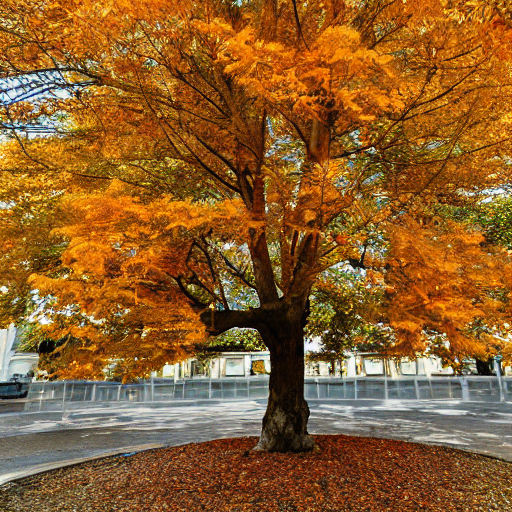

In [6]:
images = generate_images("Tree with autumn foliage", pipeline, 2)

images[0]

This is a nice starting place. But the `pipeline` takes more arguments, to give users more flexibility with how images are generated. Let's add those in. We'll start with the guidance scale, which we can change with the `guidance_scale` argument in the pipeline.

**Task 6.6.5:** Change your `generate_images` to also take a `guidance` argument, with a default value of `7.5`. Also change your call to pipeline to include the argument `guidance_scale=guidance`.

In [7]:
def generate_images(prompt, pipeline, n, guidance=7.5):
    images = pipeline([prompt] * n, guidance_scale=guidance)
    return images.images

  0%|          | 0/50 [00:00<?, ?it/s]

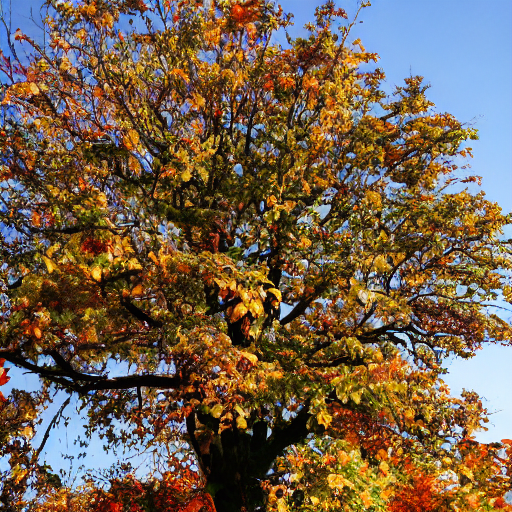

In [8]:
images = generate_images("Tree with autumn foliage", pipeline, 2, guidance=3.0)

images[0]

We can also change how many steps the model takes, by adjusting the `num_inference_steps` argument to the pipeline. Let's add that as well.

**Task 6.6.6:** Change your `generate_images` to also take a `steps` argument, with a default value of `50`. Also change your call to pipeline to include the argument `num_inference_steps=steps`.

In [9]:
def generate_images(prompt, pipeline, n, guidance=7.5, steps=50):
    images = pipeline([prompt] * n, guidance_scale=guidance, num_inference_steps=steps)
    return images.images

  0%|          | 0/20 [00:00<?, ?it/s]

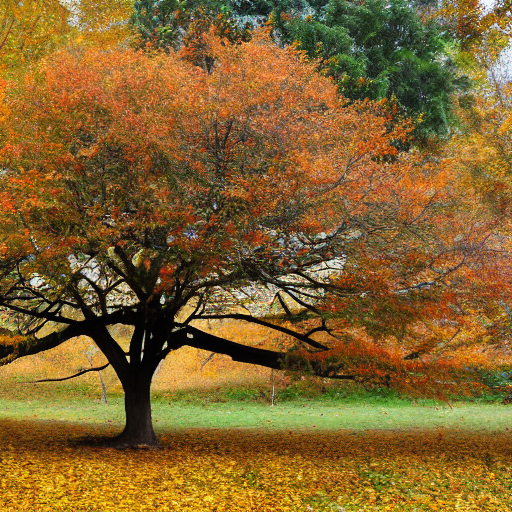

In [10]:
images = generate_images(
    "Tree with autumn foliage", pipeline, 2, guidance=7, steps=20
)

images[0]

There are other arguments to the pipeline we could change, but this should be enough for now. We don't want to overwhelm our users (or ourselves)!

One thing we saw was that we could add styles. This was actually a somewhat annoying process, so it would be nice for our users if we could do this for them. Here is a dictionary that presents different Stable Diffusion styles along with short names as keys. It'll be handy for the Streamlit app:

In [11]:
style_dict = {
    'none': '',
    'anime': 'cartoon, animated, Studio Ghibli style, cute, Japanese animation',
    'photo': 'photograph, film, 35 mm camera',
    'video game': 'rendered in unreal engine, hyper-realistic, volumetric lighting, --ar 9:16 --hd --q 2',
    'watercolor': 'painting, watercolors, pastel, composition'
}


Now we should adjust our `generate_images` to take the style name, and add the style string to the prompt. Later, our user will be able to select the nice short name and our app will take care of the rest.

**Task 6.6.7:** Change your `generate_images` to also take a `style` argument, with a default value of `"none"`. In the function, look up the style string based on the `style` argument, and add that string to the prompt.

In [15]:
def generate_images(prompt, pipeline, n, guidance=7.5, steps=50, style="none"):
    style_text = style_dict[style]
    images = pipeline([prompt + style_text] * n, 
                      guidance_scale=guidance, 
                      num_inference_steps=steps, 
                      )
    return images.images

  0%|          | 0/20 [00:00<?, ?it/s]

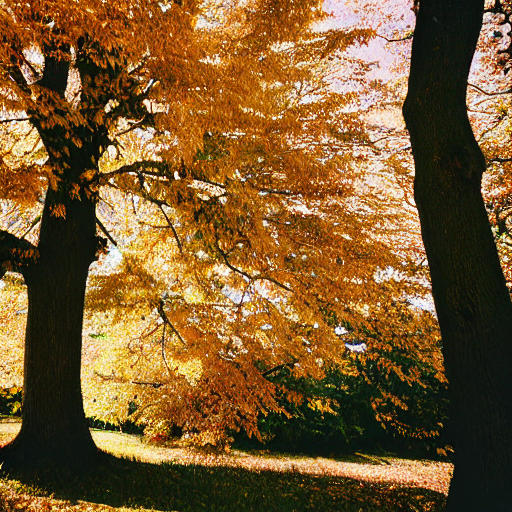

In [16]:
images = generate_images(
    "Tree with autumn foliage", pipeline, 2, steps=20, style="photo"
)

images[0]

### Streamlit App

Congratulations! You have successfully customized Stable Diffusion. Now it's time to create a Streamlit app that will present this to any user.

> **The rest of this lesson is entirely optional and it's not graded.**

Open the app script located in `app.py` and fill in the code that you have created during this lesson: the imports, the `device` and `dtype` and the functions.

You'll find that we have already created a `main()` function that will use your function's parameters.

Once you're ready to try it out, run the following in a terminal:

```bash
streamlit run app.py --browser.serverAddress 0.0.0.0 --server.port 9000
```

Now use the tab switcher to go to the `Streamlit App` tab.

![](images/streamlit-view-switch.png)